In [18]:
# Setup

import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F

import pydicom
import pandas as pd

from customModel import *

In [2]:
device = 'cuda:0'
inputs = np.load('./inputs2.npy')

inputs[:, 0] = inputs[:, 0].astype('uint8') / 255
inputs[:, 1] = (inputs[:, 1] * 255).astype('uint8') / 255

outputs = np.load('./outputs2.npy')

print(inputs.shape, outputs.shape)

(100, 2, 512, 512) (100, 6, 512, 512)


In [3]:
# Build Model

num_classes = 2
batch_size, channel, height, width = inputs.shape
x = torch.Tensor(inputs[:1])
vit = ViT(in_channels=channel, num_classes=num_classes)

model1 = torch.load('./models/label_0/20221125_190808_3_0.0055_0.0032.pt', map_location=device).to(device)
model2 = torch.load('./models/label_1/20221125_190817_3_0.0117_0.0080.pt', map_location=device).to(device)
model3 = torch.load('./models/label_2/20221125_190912_4_0.0097_0.0092.pt', map_location=device).to(device)

print("Model Implemented!")

Model Implemented!


In [4]:
# custom dataset
dataset = customDataset(X=inputs, Y=outputs)

Displaying Train Results


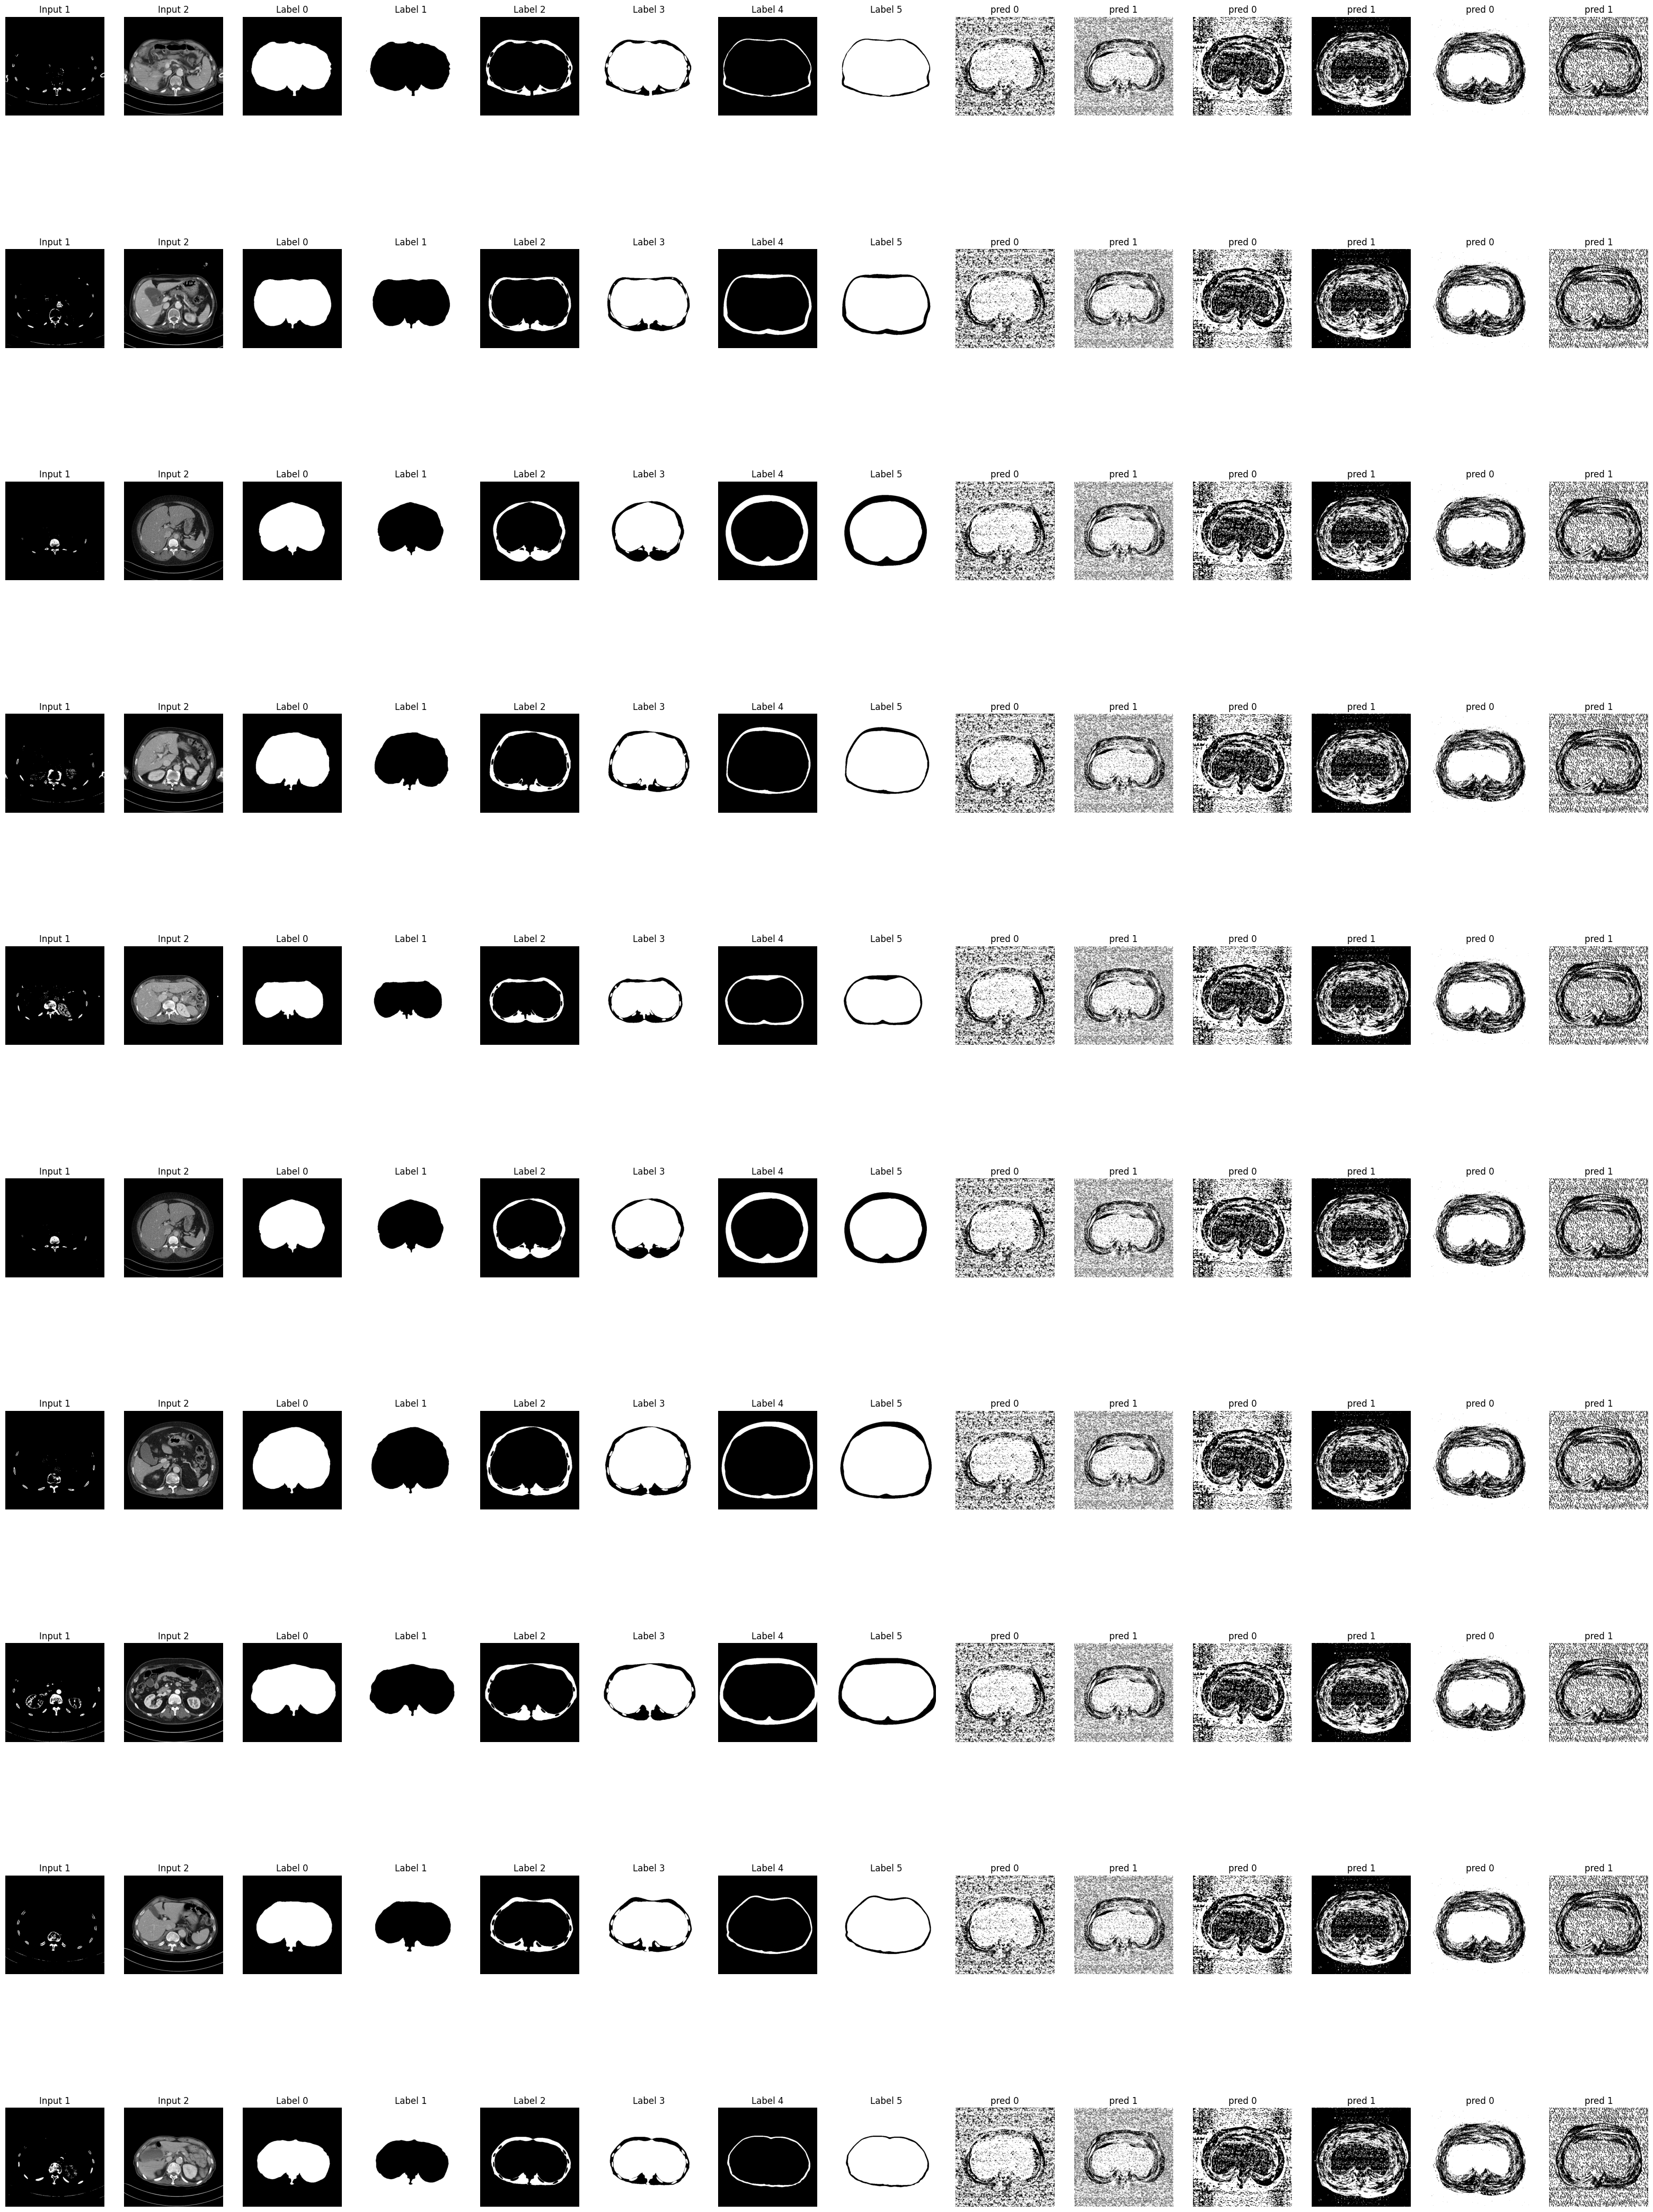

In [12]:
dataLen = 10
dataSize = 14

fig, axes = plt.subplots(dataLen, dataSize, figsize=(dataLen*4, dataSize*4))

data_choices = np.random.choice(range(len(dataset)), size=dataLen)
num = 0
data_choice = data_choices[num]
x, y = dataset[data_choice]
x = x.unsqueeze(0).to(device)
pred1 = model1(x).cpu().detach().numpy().squeeze()
pred2 = model2(x).cpu().detach().numpy().squeeze()
pred3 = model3(x).cpu().detach().numpy().squeeze()

x2 = x.cpu().detach().numpy().squeeze()
y2 = y.cpu().detach().numpy().squeeze()

for idx, ax in enumerate(axes.flat) :

    if (idx > 0) & (idx % dataSize == 0) :
        num += 1
        data_choice = data_choices[num]
        x, y = dataset[data_choice]
        x = x.unsqueeze(0).to(device)
        pred1 = model1(x).cpu().detach().numpy().squeeze()
        pred2 = model2(x).cpu().detach().numpy().squeeze()
        pred3 = model3(x).cpu().detach().numpy().squeeze()
    
        x2 = x.cpu().detach().numpy().squeeze()
        y2 = y.cpu().detach().numpy().squeeze()    
    
    if idx % dataSize < 2 :
        ax.imshow(x2[idx-num*dataSize], cmap="gray")
        title = f'Input {idx+1-num*dataSize}'
        ax.set_title(title)
        ax.axis("off")
    elif idx % dataSize < 8 :
        ax.imshow(y2[idx-2-num*dataSize], cmap="gray")
        title = f'Label {idx-2-num*dataSize}'
        ax.set_title(title)
        ax.axis("off")
    elif idx % dataSize < 10 :
        ax.imshow((pred1[idx-8-num*dataSize] > 0).astype('uint8'), 'gray')
        title = f'pred {idx-8-num*dataSize}'
        ax.set_title(title)
        ax.axis("off")
    elif idx % dataSize < 12 :
        ax.imshow((pred2[idx-10-num*dataSize] > 0).astype('uint8'), 'gray')
        title = f'pred {idx-10-num*dataSize}'
        ax.set_title(title)
        ax.axis("off")
    else :
        ax.imshow((pred3[idx-12-num*dataSize] > 0).astype('uint8'), 'gray')
        title = f'pred {idx-12-num*dataSize}'
        ax.set_title(title)
        ax.axis("off")

# Print information and display the figure.
print(f"Displaying Train Results")
plt.show()

In [14]:
def transform_to_hu(medical_image, image):
    hu_image = image * medical_image.RescaleSlope + medical_image.RescaleIntercept
    hu_image[hu_image < -1024] = -1024
    return hu_image

def apply_window(image, window_center, window_width):
    window_image = image.copy()
    image_min = window_center - (window_width / 2)
    image_max = window_center + (window_width / 2)
    window_image[window_image < image_min] = image_min
    window_image[window_image > image_max] = image_max
    return window_image

def resize_normalize(image):
    image = np.array(image, dtype=np.float64)
    image -= np.min(image)
    image /= np.max(image)
    return image

def read_dicom(path, window_width, window_level):
    image_medical = pydicom.dcmread(path)
    image_data = image_medical.pixel_array

    image_hu = transform_to_hu(image_medical, image_data)
    image_window = apply_window(image_hu.copy(), window_level, window_width)
    image_window_norm = resize_normalize(image_window)

    return image_window_norm

In [19]:
valid_list = glob("./test/dcm/*")
valid_list.sort()

# input1 = np.stack([pydicom.dcmread(x).pixel_array for x in inputList])
input2 = np.stack([read_dicom(path=x, window_width=512, window_level=0) for x in valid_list])
input3 = np.stack([read_dicom(path=x, window_width=512, window_level=100) for x in valid_list])
# inputs = np.stack([input1, input2, input3], axis=1)
inputs = np.stack([input2, input3], axis=1)

inputs[:, 0] = inputs[:, 0].astype('uint8') / 255
inputs[:, 1] = (inputs[:, 1] * 255).astype('uint8') / 255

inputs.shape

(50, 2, 512, 512)

In [20]:
def rle_encode(mask_image):
    pixels = mask_image.flatten()
    # We avoid issues with '1' at the start or end (at the corners of
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask,
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return ' '.join(str(x) for x in runs)

In [21]:
inputs = torch.Tensor(inputs)
preds = []
for x in tqdm(inputs) :
    x = x.unsqueeze(0).to(device)
    pred1 = model1(x).cpu().detach().numpy().squeeze()    
    pred2 = model2(x).cpu().detach().numpy().squeeze()    
    pred3 = model3(x).cpu().detach().numpy().squeeze()    
    
    pred1 = pred1.astype('uint8') > 0
    pred2 = pred2.astype('uint8') > 0
    pred3 = pred3.astype('uint8') > 0
    
    preds.append(rle_encode(pred1))
    preds.append(rle_encode(pred2))
    preds.append(rle_encode(pred3))
    
    
len(preds)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.28it/s]


150

In [22]:
df = pd.read_csv('./sample_submission.csv')
df['EncodedPixels'] = preds
df

ImageId                                      EncodedPixels
0    case101_1  2 50865 50868 1607 52476 21 52498 968 53467 21...
1    case101_2  2 8127 8130 511 8642 511 9154 16844 26000 511 ...
2    case101_3  2 33586 33590 504 34095 13 34109 496 34607 503...
3    case102_1  2 50865 50868 1607 52476 21 52498 968 53467 21...
4    case102_2  2 7615 7618 1023 8642 511 9154 16844 26000 511...
..         ...                                                ...
145  case149_2  2 8125 8128 1 8130 511 8642 511 9154 16844 260...
146  case149_3  2 33586 33590 504 34095 13 34109 496 34607 503...
147  case150_1  2 50865 50868 1607 52476 21 52498 968 53467 21...
148  case150_2  2 7615 7618 1023 8642 511 9154 16844 26000 511...
149  case150_3  2 33586 33590 504 34095 13 34109 496 34607 503...

[150 rows x 2 columns]

In [23]:
df.to_csv('submission.csv', index=False)